# **AERODYNAMICS – AIRCRAFT MAINTENANCE PREDICTION**

#### 1. Importing Libraries

In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU

In [3]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)

# We wil print some rows of the train data
train_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,-0.0034,0.0001,100.0,518.67,642.19,1584.07,1395.16,14.62,...,8130.69,8.4311,0.03,392,2388,100.0,38.88,23.3255,NaN,NaN
96,1,97,0.0035,-0.0003,100.0,518.67,642.07,1595.77,1407.81,14.62,...,8128.74,8.4105,0.03,392,2388,100.0,39.01,23.2963,NaN,NaN
97,1,98,0.0006,0.0004,100.0,518.67,642.00,1591.11,1404.56,14.62,...,8127.89,8.4012,0.03,391,2388,100.0,38.96,23.2554,NaN,NaN
98,1,99,-0.0005,-0.0000,100.0,518.67,642.46,1592.73,1406.13,14.62,...,8131.77,8.4481,0.03,393,2388,100.0,38.82,23.2323,NaN,NaN


In [4]:
# Let's drop the NAN columns 26 and 27 using the dropna() method.
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [5]:
print(len(train_df))
print(len(test_df))

20631
13096


In [6]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head(2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [7]:
test_df.head(2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916


In [8]:
# Load the ground truth for the test data, which indicates the remaining useful cycles for the engines

truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [9]:
# We wil drop the NAN column
truth_df.dropna(axis=1, inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


#### 2. Data Preprocessing

In [10]:
# method and specify which columns are to be considered while sorting using the parameter.

train_df.sort_values(['id','cycle'], inplace=True)
test_df.sort_values(['id','cycle'], inplace=True)

In [11]:
# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# Each engine runs until failure in the training dataset.
# max_cycle = the last cycle number for that engine → defines its failure point.
# Remaining Useful Life (RUL) = max_cycle – current_cycle.
# Without max_cycle, we wouldn’t know how much life is left.

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
train_df['RUL'] = train_df['max'] - train_df['cycle']

#The RUL is calculated for each id.
train_df[['id','cycle','max','RUL']].head()

,id,cycle,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [12]:
# We do not need "max" anymore.
train_df.drop('max', axis=1, inplace=True)

In [13]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

# create a ground truth label for classification

# w1 = 30 means we flag an engine as “about to fail” if RUL ≤ 30 cycles.
# Why 30? → It’s a practical early-warning threshold:
# Too small (e.g., 5 cycles) → not enough time to schedule maintenance.
# Too large (e.g., 100 cycles) → too many false alarms.
# Industry typically uses 20–30 cycles as a balance between safety and efficiency.

Ground truth = the true label provided in data.

For test engines, NASA only gives partial cycles (not until failure).

So they provide PM_truth.txt, which contains the true RUL at the last cycle of each test engine.

We need this to evaluate predictions.

#### 3.2 Normalize training data

In [14]:
# Make a separate feature for the normalized value of the cycle column.
train_df['cycle_norm'] = train_df['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = train_df[['id','cycle','RUL','failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

# Neural networks converge faster when inputs are scaled (0–1).
# Prevents exploding/vanishing gradients.
# Ensures sensors with different ranges (e.g., pressure vs temperature) are comparable

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


In [15]:
# We will perform MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']

# MinMax normalization (from 0 to 1) of the sensor data only
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)

#Join the normalized and non-normalized data (it does not have 'RUL' and 'failure_within_w1')
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [16]:
# Let's calculate the total RUL by summing up the maximum cycles given in the test set and the
# ground truth additional RUL.
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']

# The respective id can be obtained by adding 1 to the index, as the index starts from 0.
truth_df['id'] = truth_df.index + 1

# Add the max cycles given in the test set and the additional RUL given in the ground truth DataFrame.
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# Generate the RUL for the test data.
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# Generate the label columns w0 and w1 for the test data.
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,failure_within_w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


#### 4. EDA

Let's see how the sensor values change for a particular engine id, say id=1.

<Axes: >

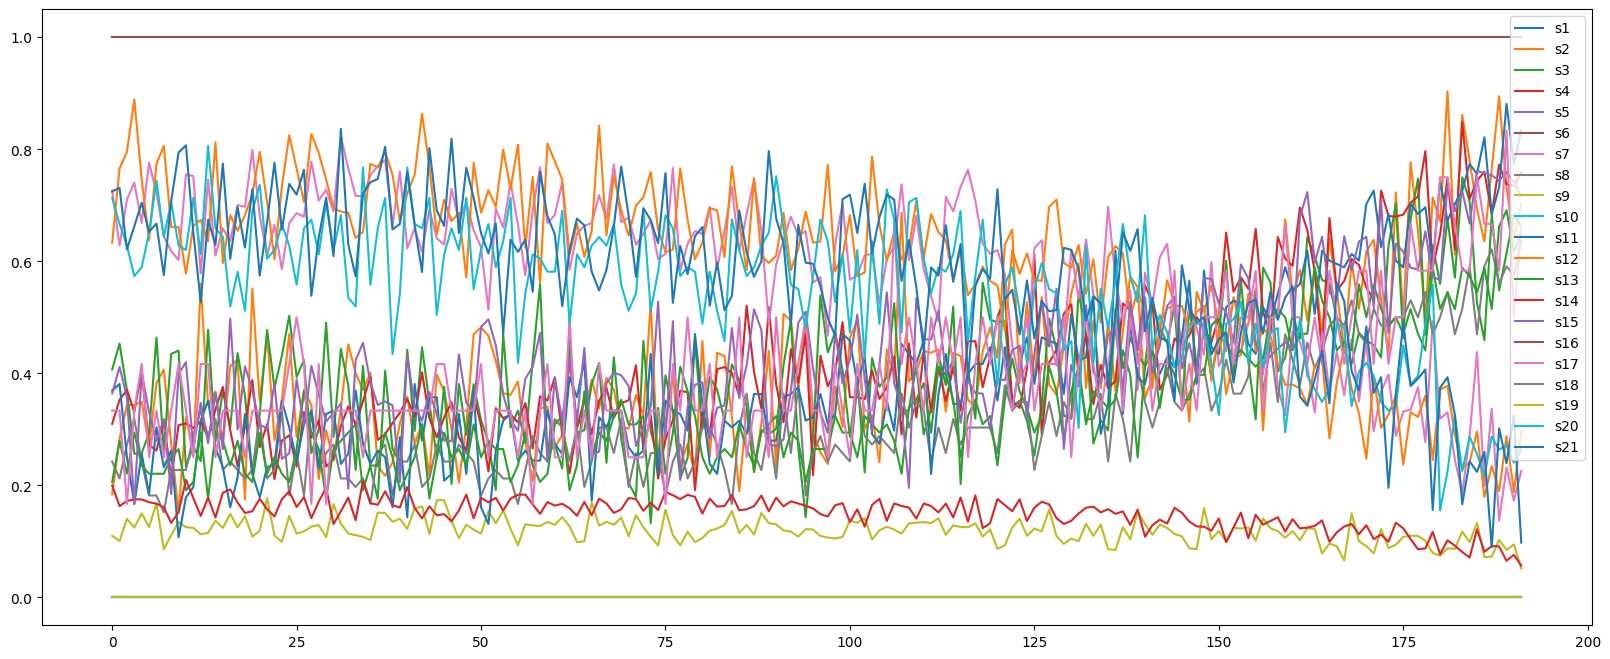

In [17]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20, 8))

<Axes: >

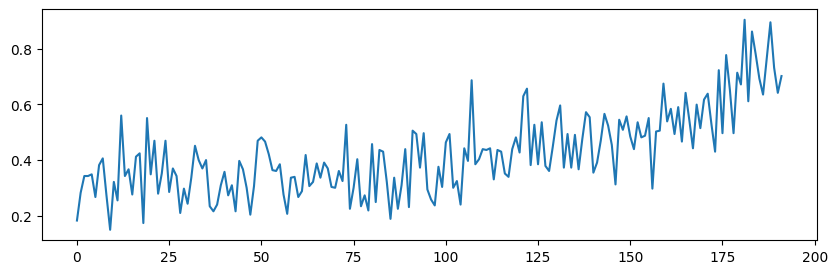

In [18]:
train_df[train_df.id==1][sensor_cols[1]].plot(figsize=(10, 3))

Sensor 1 values increase when the cycle of number incrceases.
Sensor 6 values decrease when the cycle of number increases.
Most other sensors exhibit either an increasing or decreasing trend.

<Axes: >

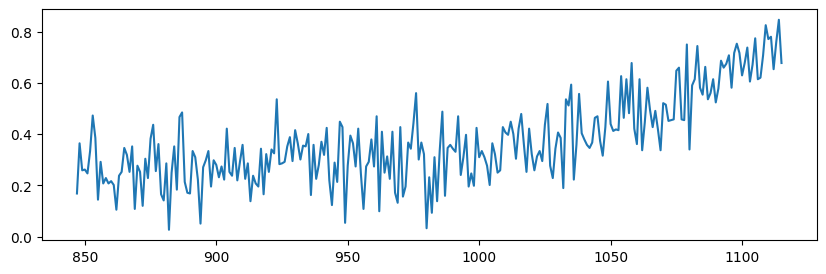

In [19]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

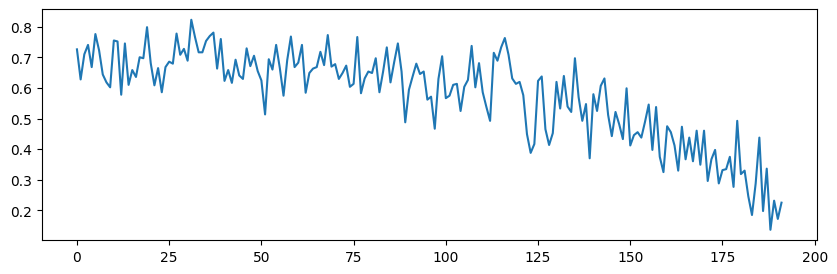

In [20]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

We have plotted sensor1 observations for id 1 and id 5.

Both observations have an upward trend with increasing cycles.

<Axes: >

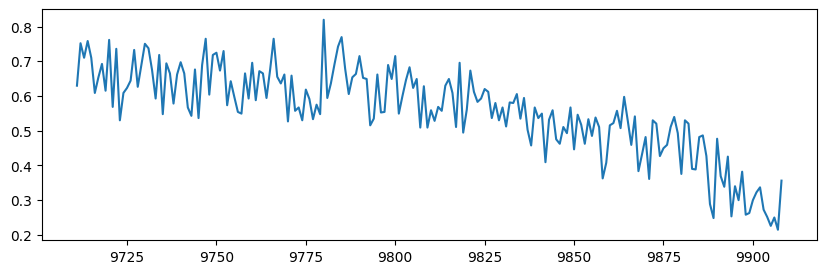

In [21]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

We have plotted sensor6 observations for id 1 and id 50.

Both observations have a downward trend with increasing cycles.

We can sew that when the sensor values approach a particular value, the aircraft may fail to work soon.

#### 5. Generating Input Sequence

In [22]:
# The sequence length to be used for predictions is as follows:
sequence_length = 50

In [23]:
# The function to generate sequences (samples, time steps, features) for a particular engine id is as follows:

def sequence_generator(feature_df, seq_length, seq_cols):
    # We will not be using any sequence below seq_length.
    # Convert the DataFrame into a NumPy 2D array.
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]

    # We want to generate sequences of 50 timesteps at a time.
    # Hence, we will iterate over two sets of indices: (0,142),(50,192).
    # For example, id1 has 192 rows, and its sequence_length is equal to 50.
    # 0 50 -> From row 0 to row 50
    # 1 51 -> From row 1 to row 51
    # 2 52 -> From row 2 to row 52
    # ...
    # 141 191 -> From row 111 to 191

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [24]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, ["s2"])) # We take only one feature (s2).
           for id in train_df['id'].unique())

# Concatenate the sequences of different engine ids into one array and convert that into a NumPy array
# [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
#print(list(seq_gen))
seq_set = np.concatenate(list(seq_gen)).astype(np.float32)

# Let’s print the shape of the seq_set  (number of samples, number of time steps, number of features)
seq_set.shape


(15631, 50, 1)

In [25]:
# The function to generate labels is as follows:
def label_generator(label_df, seq_length, label):
    # Funtion will return
    # This function will return the following:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    # Convert the labels into a NumPy 2D array.

    label_array = label_df[label].values
    num_elements = label_array.shape[0]
        # Remove the first label, as the first prediction will be the (seq_length+1)th label.
    return label_array[seq_length:num_elements, :]

In [26]:
# Generate labels [[142,1], [121, 1], [3]] --> [1, 2, 3] (ntotal, 1).
label_gen = [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1'])
             for id in train_df['id'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)
label_set.shape

(15631, 1)

#### 6. RNN Models

6.1 Simple RNN [1 Feature]

In [27]:
out_dim = label_set.shape[1] # 1 label/output for one sequence.
features_dim = seq_set.shape[2] # Number of features (1)


print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd = Sequential()

# Add the RNN unit.
# Understand the parameters.
RNN_fwd.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=1,
         return_sequences=False))
RNN_fwd.add(Dropout(0.2))

RNN_fwd.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd.summary())

# Define the path to save the model.
RNN_fwd_path = '/CE/RNN_fwd.h5'


Features dimension:  1
Output dimension:  1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
import time
epochs = 100
batch_size = 100
start = time.time()

# Fit the network.
RNN_fwd_history = RNN_fwd.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/100


149/149 - 6s - 38ms/step - accuracy: 0.8017 - loss: 0.5430 - val_accuracy: 0.8018 - val_loss: 0.5108
Epoch 2/100


149/149 - 2s - 13ms/step - accuracy: 0.8017 - loss: 0.5314 - val_accuracy: 0.8018 - val_loss: 0.5050
Epoch 3/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.5222 - val_accuracy: 0.8018 - val_loss: 0.5027
Epoch 4/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.5245 - val_accuracy: 0.8018 - val_loss: 0.5015
Epoch 5/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.5206 - val_accuracy: 0.8018 - val_loss: 0.5009
Epoch 6/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.5173 - val_accuracy: 0.8018 - val_loss: 0.5004
Epoch 7/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.5124 - val_accuracy: 0.8018 - val_loss: 0.4998
Epoch 8/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.5113 - val_accuracy: 0.8018 - val_loss: 0.4995
Epoch 9/100


149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.5091 - val_accuracy: 0.8018 - val_loss: 0.4992
Epoch 10/100


149/149 - 1s - 7ms/step - accuracy: 0.8017 - loss: 0.5081 - val_accuracy: 0.8018 - val_loss: 0.4991
Epoch 11/100


149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.5089 - val_accuracy: 0.8018 - val_loss: 0.4989
Epoch 12/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.5058 - val_accuracy: 0.8018 - val_loss: 0.4988
Epoch 13/100


149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.5066 - val_accuracy: 0.8018 - val_loss: 0.4987
Epoch 14/100


149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.5044 - val_accuracy: 0.8018 - val_loss: 0.4986
Epoch 15/100


149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.5024 - val_accuracy: 0.8018 - val_loss: 0.4984
Epoch 16/100


149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.5027 - val_accuracy: 0.8018 - val_loss: 0.4984
Epoch 17/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.5017 - val_accuracy: 0.8018 - val_loss: 0.4983
Epoch 18/100
149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.5023 - val_accuracy: 0.8018 - val_loss: 0.4983
Epoch 19/100


149/149 - 1s - 6ms/step - accuracy: 0.8017 - loss: 0.5014 - val_accuracy: 0.8018 - val_loss: 0.4982
Epoch 20/100


149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.5002 - val_accuracy: 0.8018 - val_loss: 0.4982
Epoch 21/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.5005 - val_accuracy: 0.8018 - val_loss: 0.4982
Epoch 22/100


149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4996 - val_accuracy: 0.8018 - val_loss: 0.4981
Epoch 23/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4993 - val_accuracy: 0.8018 - val_loss: 0.4981
Epoch 24/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4990 - val_accuracy: 0.8018 - val_loss: 0.4981
Epoch 25/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4994 - val_accuracy: 0.8018 - val_loss: 0.4981
Epoch 26/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4988 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 27/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4989 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 28/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4987 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 29/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4990 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 30/100


149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.4989 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 31/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4983 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 32/100


149/149 - 1s - 6ms/step - accuracy: 0.8017 - loss: 0.4984 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 33/100


149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.4983 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 34/100
149/149 - 1s - 7ms/step - accuracy: 0.8017 - loss: 0.4986 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 35/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4987 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 36/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4982 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 37/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4985 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 38/100


149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.4982 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 39/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4982 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 40/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 41/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4980 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 42/100
149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4986 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 43/100
149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.4983 - val_accuracy: 0.8018 - val_loss: 0.4980
Epoch 44/100


149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.4982 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 45/100
149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4983 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 46/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4982 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 47/100


149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4982 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 48/100


149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.4983 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 49/100
149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4982 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 50/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 51/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4982 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 52/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 53/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 54/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 55/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 56/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 57/100
149/149 - 1s - 6ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 58/100
149/149 - 1s - 6ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 59/100


149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 60/100
149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 61/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 62/100
149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 63/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 64/100


149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 65/100


149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 66/100
149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 67/100
149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 68/100
149/149 - 1s - 9ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 69/100
149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 70/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 71/100
149/149 - 1s - 8ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 72/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4979
Epoch 73/100
149/149 - 1s - 5ms/step - accuracy: 0.8017 - loss: 0.4981 - val_accuracy: 0.8018 - val_loss: 0.4

In [29]:
# The function for plotting the change in the model’s accuracy on the train and validation sets is as follows:
def plot_model_accuracy(model_name_history, width = 10, height = 10):

  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['accuracy'])
  plt.plot(model_name_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
#Call the function.

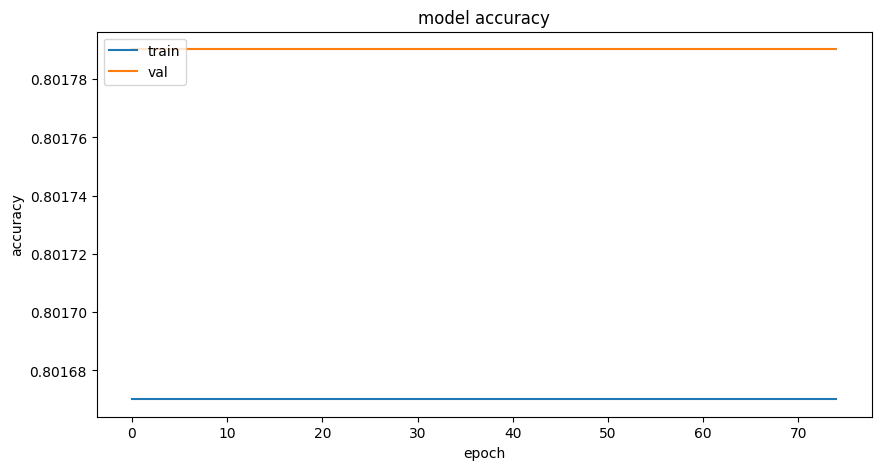

In [30]:
#Call the function.
plot_model_accuracy(RNN_fwd_history,10,5)

In [31]:
# We will define a function to plot the change in the loss on the train and validation sets.
def plot_training_curve(model_name_history, width = 10, height = 10):
  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['loss'])
  plt.plot(model_name_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

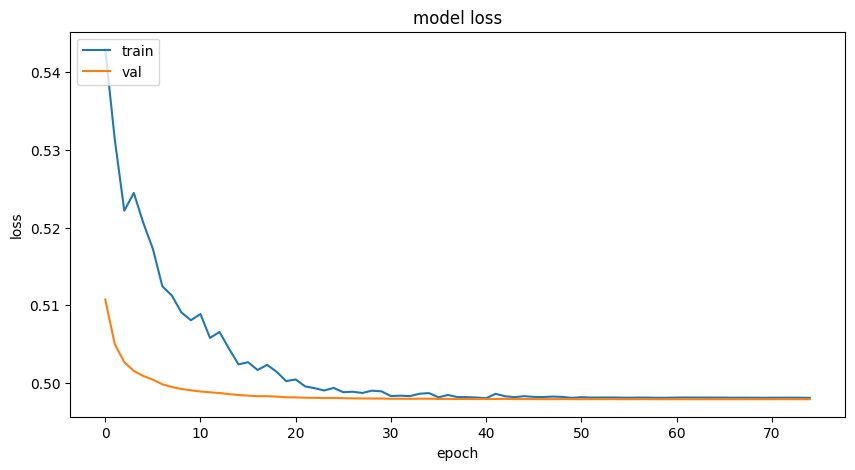

In [32]:
#Call the function.
plot_training_curve(RNN_fwd_history,10,5)

Model evaluation on train set :-

In [33]:
def analyze_model_on_train_set(input_sequence_set, model_name):

  # The training metrics are as follows:
  model_history_scores = model_name.evaluate(input_sequence_set, label_set, verbose=1, batch_size=50)
  print('Train Accurracy: {}'.format(model_history_scores[1]))

  # Make predictions and compute the confusion matrix.
  y_pred = (model_name.predict(input_sequence_set, verbose=1, batch_size=200) > 0.5).astype("int32")
  y_true = label_set

  test_set = pd.DataFrame(y_pred)
  test_set.to_csv('binary_submit_train.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_cm = confusion_matrix(y_true, y_pred)
  print(model_cm)

  # Compute the precision and recall.
  model_precision = precision_score(y_true, y_pred)
  model_recall = recall_score(y_true, y_pred)
  print( 'Train Precision = ', model_precision, '\n', 'Train Recall = ', model_recall)

# Call the function.
analyze_model_on_train_set(seq_set, RNN_fwd)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8030 - loss: 0.4962
Train Accurracy: 0.8016761541366577
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12531     0]
 [ 3100     0]]
Train Precision =  0.0 
 Train Recall =  0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model evaluation on test set :-

In [34]:
def analyze_model_on_test_set(input_sequence_columns, model_path, width= 10, height=5):
  # We will consider all the last sequences of the test set.
  last_test_seq = [test_df[test_df['id']==id][input_sequence_columns].values[-sequence_length:]
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
  last_test_seq = np.asarray(last_test_seq).astype(np.float32)

  # Get the labels of the test set.
  y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
  last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
  last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

  # If the best model weights were saved, load them.
  if os.path.isfile(model_path):
    print("using " + model_path)
    model_estimator = load_model(model_path)

  # Test the metrics.
  start = time.time()
  scores_test = model_estimator.evaluate(last_test_seq, last_test_label, verbose=2)
  end = time.time()
  print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

  print('Test Accurracy: {}'.format(scores_test[1]))

  # Make predictions and compute the confusion matrix.
  y_model_estimator_pred_test = (model_estimator.predict(last_test_seq) >0.5).astype("int32")
  y_true_test = last_test_label

  test_set = pd.DataFrame(y_model_estimator_pred_test)
  test_set.to_csv('binary_submit_test.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_estimator_conf_m = confusion_matrix(y_true_test, y_model_estimator_pred_test)
  print(model_estimator_conf_m)

  # Compute the precision and recall values.
  model_estimator_precision_test = precision_score(y_true_test, y_model_estimator_pred_test)
  model_estimator_recall_test = recall_score(y_true_test, y_model_estimator_pred_test)
  f1_test = 2 * (model_estimator_precision_test * model_estimator_recall_test) / (model_estimator_precision_test + model_estimator_recall_test)
  print( 'Test Precision: ', model_estimator_precision_test, '\n', 'Test Recall: ', model_estimator_recall_test,'\n', 'Test F1-score:', f1_test )

  # Plot the predicted data in blue and the
  # actual data in green to visually verify the accuracy of the model.
  fig_verify = plt.figure(figsize=(10, 5))
  plt.plot(y_model_estimator_pred_test, color="blue")
  plt.plot(y_true_test, color="green")
  plt.title('prediction')
  plt.ylabel('value')
  plt.xlabel('row')
  plt.legend(['predicted', 'actual data'], loc='upper left')
  plt.show()
#Call the function.
analyze_model_on_test_set(["s2"], RNN_fwd_path, 10, 5)

using /CE/RNN_fwd.h5
3/3 - 1s - 291ms/step - accuracy: 0.7312 - loss: 0.5965
Total time taken for inferencing:  1.01  secs
Test Accurracy: 0.7311828136444092
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[68  0]
 [25  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ZeroDivisionError: float division by zero

6.2 Simple RNN With 25 Features

Let's now consider data from all 21 sensors and 3 settings as well. This will lead to 25 features in the input sequence set.

In [35]:
# Pick the feature columns.
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols_25 = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols_25.extend(sensor_cols) # Add the elements of sensor_cols into sequence_cols.

In [36]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols_25)) #We will take all the features (25).
           for id in train_df['id'].unique())

# Concatenate the sequences of the different engine ids into one and convert it into a NumPy array [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
seq_set_f25 = np.concatenate(list(seq_gen)).astype(np.float32)

#The shape denotes (number of samples, number of time steps, number of features).
seq_set_f25.shape

(15631, 50, 25)

In [37]:
features_dim = seq_set_f25.shape[2] # number of features (25).
out_dim = label_set.shape[1] # One label (failure_within_w1).

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd_2 = Sequential()

# Understanding return_sequences and the connection across RNN layers:
# We have to return the sequences from the first layer so the next layer can get the sequence.

RNN_fwd_2.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=5,
         return_sequences=True))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd_2.summary())

# Define the path to save the model.
RNN_fwd_2_path = '/CE/RNN_fwd_2.h5'


Features dimension:  25
Output dimension:  1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50, 5)          │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186 (744.00 B)

 Trainable params: 186 (744.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
import time
epochs = 100
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_2_history = RNN_fwd_2.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/100


75/75 - 10s - 136ms/step - accuracy: 0.7231 - loss: 0.5960 - val_accuracy: 0.8018 - val_loss: 0.5164
Epoch 2/100


75/75 - 1s - 11ms/step - accuracy: 0.8218 - loss: 0.4821 - val_accuracy: 0.8964 - val_loss: 0.3991
Epoch 3/100


75/75 - 1s - 16ms/step - accuracy: 0.9084 - loss: 0.3738 - val_accuracy: 0.9118 - val_loss: 0.3304
Epoch 4/100


75/75 - 1s - 17ms/step - accuracy: 0.9168 - loss: 0.3257 - val_accuracy: 0.9335 - val_loss: 0.2817
Epoch 5/100


75/75 - 1s - 10ms/step - accuracy: 0.9191 - loss: 0.2931 - val_accuracy: 0.9335 - val_loss: 0.2584
Epoch 6/100


75/75 - 1s - 10ms/step - accuracy: 0.9221 - loss: 0.2715 - val_accuracy: 0.9386 - val_loss: 0.2324
Epoch 7/100
75/75 - 1s - 17ms/step - accuracy: 0.9247 - loss: 0.2569 - val_accuracy: 0.9348 - val_loss: 0.2368
Epoch 8/100


75/75 - 1s - 10ms/step - accuracy: 0.9262 - loss: 0.2417 - val_accuracy: 0.9322 - val_loss: 0.2187
Epoch 9/100


75/75 - 1s - 10ms/step - accuracy: 0.9309 - loss: 0.2297 - val_accuracy: 0.9309 - val_loss: 0.2082
Epoch 10/100


75/75 - 1s - 18ms/step - accuracy: 0.9316 - loss: 0.2200 - val_accuracy: 0.9322 - val_loss: 0.2049
Epoch 11/100


75/75 - 1s - 17ms/step - accuracy: 0.9314 - loss: 0.2139 - val_accuracy: 0.9361 - val_loss: 0.1819
Epoch 12/100
75/75 - 1s - 9ms/step - accuracy: 0.9342 - loss: 0.2071 - val_accuracy: 0.9309 - val_loss: 0.2107
Epoch 13/100
75/75 - 1s - 9ms/step - accuracy: 0.9341 - loss: 0.2008 - val_accuracy: 0.9297 - val_loss: 0.2039
Epoch 14/100
75/75 - 1s - 17ms/step - accuracy: 0.9346 - loss: 0.1977 - val_accuracy: 0.9309 - val_loss: 0.1932
Epoch 15/100
75/75 - 1s - 9ms/step - accuracy: 0.9349 - loss: 0.1920 - val_accuracy: 0.9335 - val_loss: 0.1819
Epoch 16/100


75/75 - 1s - 10ms/step - accuracy: 0.9378 - loss: 0.1837 - val_accuracy: 0.9361 - val_loss: 0.1655
Epoch 17/100
75/75 - 1s - 9ms/step - accuracy: 0.9378 - loss: 0.1869 - val_accuracy: 0.9258 - val_loss: 0.1906
Epoch 18/100


75/75 - 1s - 10ms/step - accuracy: 0.9367 - loss: 0.1829 - val_accuracy: 0.9399 - val_loss: 0.1508
Epoch 19/100
75/75 - 1s - 9ms/step - accuracy: 0.9382 - loss: 0.1807 - val_accuracy: 0.9373 - val_loss: 0.1604
Epoch 20/100
75/75 - 1s - 9ms/step - accuracy: 0.9359 - loss: 0.1792 - val_accuracy: 0.9361 - val_loss: 0.1648
Epoch 21/100
75/75 - 1s - 17ms/step - accuracy: 0.9384 - loss: 0.1746 - val_accuracy: 0.9399 - val_loss: 0.1545
Epoch 22/100


75/75 - 1s - 10ms/step - accuracy: 0.9389 - loss: 0.1728 - val_accuracy: 0.9373 - val_loss: 0.1393
Epoch 23/100
75/75 - 1s - 10ms/step - accuracy: 0.9394 - loss: 0.1700 - val_accuracy: 0.9386 - val_loss: 0.1489
Epoch 24/100
75/75 - 1s - 11ms/step - accuracy: 0.9402 - loss: 0.1693 - val_accuracy: 0.9361 - val_loss: 0.1649
Epoch 25/100
75/75 - 1s - 16ms/step - accuracy: 0.9414 - loss: 0.1677 - val_accuracy: 0.9335 - val_loss: 0.1527
Epoch 26/100
75/75 - 1s - 16ms/step - accuracy: 0.9395 - loss: 0.1658 - val_accuracy: 0.9373 - val_loss: 0.1630
Epoch 27/100
75/75 - 1s - 10ms/step - accuracy: 0.9396 - loss: 0.1652 - val_accuracy: 0.9386 - val_loss: 0.1528
Epoch 28/100
75/75 - 1s - 17ms/step - accuracy: 0.9386 - loss: 0.1682 - val_accuracy: 0.9399 - val_loss: 0.1444
Epoch 29/100


75/75 - 1s - 17ms/step - accuracy: 0.9401 - loss: 0.1645 - val_accuracy: 0.9399 - val_loss: 0.1343
Epoch 30/100
75/75 - 1s - 9ms/step - accuracy: 0.9413 - loss: 0.1626 - val_accuracy: 0.9412 - val_loss: 0.1484
Epoch 31/100
75/75 - 1s - 17ms/step - accuracy: 0.9415 - loss: 0.1598 - val_accuracy: 0.9450 - val_loss: 0.1533
Epoch 32/100


75/75 - 1s - 10ms/step - accuracy: 0.9424 - loss: 0.1604 - val_accuracy: 0.9437 - val_loss: 0.1286
Epoch 33/100
75/75 - 1s - 9ms/step - accuracy: 0.9403 - loss: 0.1594 - val_accuracy: 0.9450 - val_loss: 0.1420
Epoch 34/100


75/75 - 1s - 10ms/step - accuracy: 0.9430 - loss: 0.1530 - val_accuracy: 0.9476 - val_loss: 0.1181
Epoch 35/100


75/75 - 1s - 17ms/step - accuracy: 0.9440 - loss: 0.1542 - val_accuracy: 0.9514 - val_loss: 0.1073
Epoch 36/100
75/75 - 1s - 10ms/step - accuracy: 0.9428 - loss: 0.1551 - val_accuracy: 0.9437 - val_loss: 0.1356
Epoch 37/100
75/75 - 1s - 16ms/step - accuracy: 0.9437 - loss: 0.1533 - val_accuracy: 0.9463 - val_loss: 0.1322
Epoch 38/100
75/75 - 1s - 10ms/step - accuracy: 0.9440 - loss: 0.1527 - val_accuracy: 0.9476 - val_loss: 0.1249
Epoch 39/100
75/75 - 1s - 17ms/step - accuracy: 0.9472 - loss: 0.1483 - val_accuracy: 0.9514 - val_loss: 0.1097
Epoch 40/100
75/75 - 1s - 9ms/step - accuracy: 0.9477 - loss: 0.1494 - val_accuracy: 0.9386 - val_loss: 0.1645
Epoch 41/100
75/75 - 1s - 9ms/step - accuracy: 0.9453 - loss: 0.1498 - val_accuracy: 0.9412 - val_loss: 0.1324
Epoch 42/100
75/75 - 1s - 17ms/step - accuracy: 0.9450 - loss: 0.1465 - val_accuracy: 0.9450 - val_loss: 0.1162
Epoch 43/100


75/75 - 1s - 10ms/step - accuracy: 0.9477 - loss: 0.1475 - val_accuracy: 0.9501 - val_loss: 0.1065
Epoch 44/100


75/75 - 1s - 17ms/step - accuracy: 0.9444 - loss: 0.1518 - val_accuracy: 0.9783 - val_loss: 0.0792
Epoch 45/100
75/75 - 1s - 16ms/step - accuracy: 0.9454 - loss: 0.1509 - val_accuracy: 0.9437 - val_loss: 0.1101
Epoch 46/100
75/75 - 1s - 9ms/step - accuracy: 0.9502 - loss: 0.1414 - val_accuracy: 0.9629 - val_loss: 0.0970
Epoch 47/100
75/75 - 1s - 17ms/step - accuracy: 0.9467 - loss: 0.1453 - val_accuracy: 0.9501 - val_loss: 0.1030
Epoch 48/100
75/75 - 1s - 18ms/step - accuracy: 0.9492 - loss: 0.1411 - val_accuracy: 0.9514 - val_loss: 0.1018
Epoch 49/100


75/75 - 1s - 10ms/step - accuracy: 0.9508 - loss: 0.1373 - val_accuracy: 0.9770 - val_loss: 0.0727
Epoch 50/100
75/75 - 1s - 16ms/step - accuracy: 0.9506 - loss: 0.1363 - val_accuracy: 0.9501 - val_loss: 0.1166
Epoch 51/100
75/75 - 1s - 9ms/step - accuracy: 0.9506 - loss: 0.1347 - val_accuracy: 0.9552 - val_loss: 0.1079
Epoch 52/100
75/75 - 1s - 9ms/step - accuracy: 0.9494 - loss: 0.1395 - val_accuracy: 0.9616 - val_loss: 0.0804
Epoch 53/100
75/75 - 1s - 9ms/step - accuracy: 0.9494 - loss: 0.1399 - val_accuracy: 0.9412 - val_loss: 0.1308
Epoch 54/100
75/75 - 1s - 9ms/step - accuracy: 0.9512 - loss: 0.1359 - val_accuracy: 0.9642 - val_loss: 0.0821
Epoch 55/100
75/75 - 1s - 9ms/step - accuracy: 0.9507 - loss: 0.1356 - val_accuracy: 0.9514 - val_loss: 0.1114
Epoch 56/100
75/75 - 1s - 17ms/step - accuracy: 0.9530 - loss: 0.1286 - val_accuracy: 0.9488 - val_loss: 0.1181
Epoch 57/100
75/75 - 1s - 9ms/step - accuracy: 0.9522 - loss: 0.1324 - val_accuracy: 0.9655 - val_loss: 0.0818
Epoch 58/10

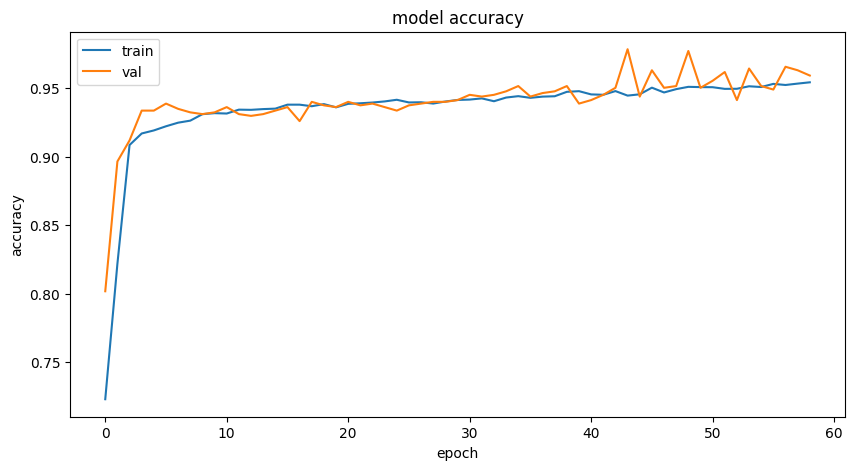

In [39]:
plot_model_accuracy(RNN_fwd_2_history, 10, 5)

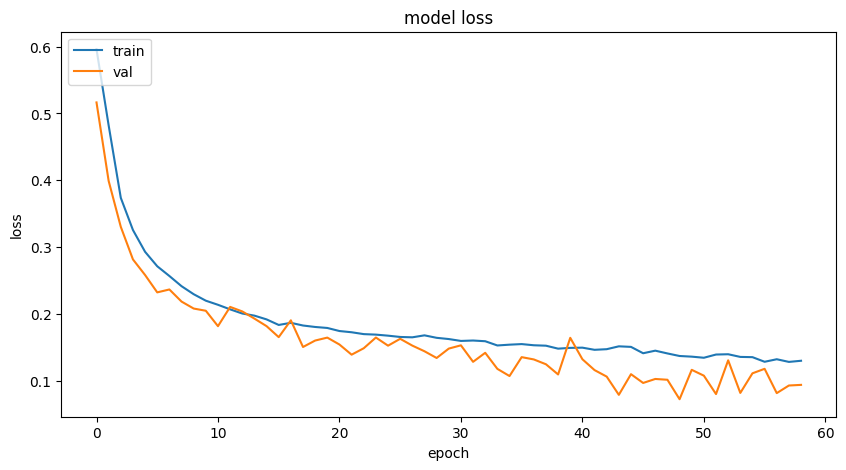

In [40]:
plot_training_curve(RNN_fwd_2_history,10,5)

#### 7. Model Building with LSTM

In [41]:
# Model - (100 LSTM units with 0.2 dropout) +
#         (50 LSTM units with 0.2 dropout) +
#         (dense layer with sigmoid activation)

features_dim = seq_set_f25.shape[2] # number of features
out_dim = label_set.shape[1] # 1 Label (Target variable is failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model = Sequential()

# Understanding of return_sequences and connection across LSTM layers
model.add(LSTM(
         input_shape=(sequence_length, features_dim),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Define path to save model
model_path = '/CE/binary_model.h5'


Features dimension:  25
Output dimension:  1


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [42]:
import time
epochs = 100
batch_size = 100
start = time.time()

# Fit the network
history = model.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/100


149/149 - 6s - 42ms/step - accuracy: 0.9244 - loss: 0.1805 - val_accuracy: 0.9680 - val_loss: 0.0805
Epoch 2/100


149/149 - 1s - 9ms/step - accuracy: 0.9588 - loss: 0.1016 - val_accuracy: 0.9655 - val_loss: 0.0742
Epoch 3/100
149/149 - 2s - 16ms/step - accuracy: 0.9666 - loss: 0.0798 - val_accuracy: 0.9540 - val_loss: 0.0805
Epoch 4/100


149/149 - 3s - 18ms/step - accuracy: 0.9710 - loss: 0.0714 - val_accuracy: 0.9744 - val_loss: 0.0555
Epoch 5/100
149/149 - 3s - 19ms/step - accuracy: 0.9706 - loss: 0.0715 - val_accuracy: 0.9437 - val_loss: 0.1824
Epoch 6/100


149/149 - 1s - 9ms/step - accuracy: 0.9726 - loss: 0.0642 - val_accuracy: 0.9770 - val_loss: 0.0523
Epoch 7/100
149/149 - 1s - 9ms/step - accuracy: 0.9722 - loss: 0.0643 - val_accuracy: 0.9744 - val_loss: 0.0538
Epoch 8/100


149/149 - 3s - 17ms/step - accuracy: 0.9751 - loss: 0.0571 - val_accuracy: 0.9783 - val_loss: 0.0460
Epoch 9/100
149/149 - 3s - 17ms/step - accuracy: 0.9751 - loss: 0.0580 - val_accuracy: 0.9706 - val_loss: 0.0610
Epoch 10/100
149/149 - 3s - 21ms/step - accuracy: 0.9778 - loss: 0.0560 - val_accuracy: 0.9808 - val_loss: 0.0466
Epoch 11/100
149/149 - 1s - 9ms/step - accuracy: 0.9768 - loss: 0.0566 - val_accuracy: 0.9744 - val_loss: 0.0536
Epoch 12/100
149/149 - 3s - 17ms/step - accuracy: 0.9749 - loss: 0.0599 - val_accuracy: 0.9744 - val_loss: 0.0600
Epoch 13/100
149/149 - 3s - 17ms/step - accuracy: 0.9772 - loss: 0.0526 - val_accuracy: 0.9731 - val_loss: 0.0549
Epoch 14/100


149/149 - 1s - 9ms/step - accuracy: 0.9792 - loss: 0.0508 - val_accuracy: 0.9885 - val_loss: 0.0275
Epoch 15/100
149/149 - 1s - 8ms/step - accuracy: 0.9799 - loss: 0.0480 - val_accuracy: 0.9693 - val_loss: 0.0723
Epoch 16/100
149/149 - 2s - 10ms/step - accuracy: 0.9808 - loss: 0.0440 - val_accuracy: 0.9731 - val_loss: 0.0629
Epoch 17/100
149/149 - 2s - 15ms/step - accuracy: 0.9809 - loss: 0.0447 - val_accuracy: 0.9693 - val_loss: 0.0748
Epoch 18/100
149/149 - 1s - 9ms/step - accuracy: 0.9797 - loss: 0.0480 - val_accuracy: 0.9859 - val_loss: 0.0313
Epoch 19/100
149/149 - 3s - 17ms/step - accuracy: 0.9815 - loss: 0.0452 - val_accuracy: 0.9872 - val_loss: 0.0387
Epoch 20/100
149/149 - 1s - 9ms/step - accuracy: 0.9816 - loss: 0.0430 - val_accuracy: 0.9731 - val_loss: 0.0631
Epoch 21/100
149/149 - 1s - 9ms/step - accuracy: 0.9822 - loss: 0.0436 - val_accuracy: 0.9706 - val_loss: 0.0710
Epoch 22/100


149/149 - 3s - 19ms/step - accuracy: 0.9828 - loss: 0.0431 - val_accuracy: 0.9885 - val_loss: 0.0266
Epoch 23/100
149/149 - 2s - 15ms/step - accuracy: 0.9811 - loss: 0.0429 - val_accuracy: 0.9808 - val_loss: 0.0407
Epoch 24/100
149/149 - 3s - 17ms/step - accuracy: 0.9810 - loss: 0.0433 - val_accuracy: 0.9783 - val_loss: 0.0416
Epoch 25/100
149/149 - 1s - 9ms/step - accuracy: 0.9830 - loss: 0.0411 - val_accuracy: 0.9770 - val_loss: 0.0596
Epoch 26/100
149/149 - 1s - 9ms/step - accuracy: 0.9819 - loss: 0.0434 - val_accuracy: 0.9808 - val_loss: 0.0466
Epoch 27/100
149/149 - 1s - 9ms/step - accuracy: 0.9827 - loss: 0.0394 - val_accuracy: 0.9757 - val_loss: 0.0603
Epoch 28/100
149/149 - 1s - 9ms/step - accuracy: 0.9844 - loss: 0.0372 - val_accuracy: 0.9795 - val_loss: 0.0545
Epoch 29/100
149/149 - 1s - 10ms/step - accuracy: 0.9820 - loss: 0.0404 - val_accuracy: 0.9757 - val_loss: 0.0493
Epoch 30/100
149/149 - 2s - 16ms/step - accuracy: 0.9846 - loss: 0.0367 - val_accuracy: 0.9706 - val_loss

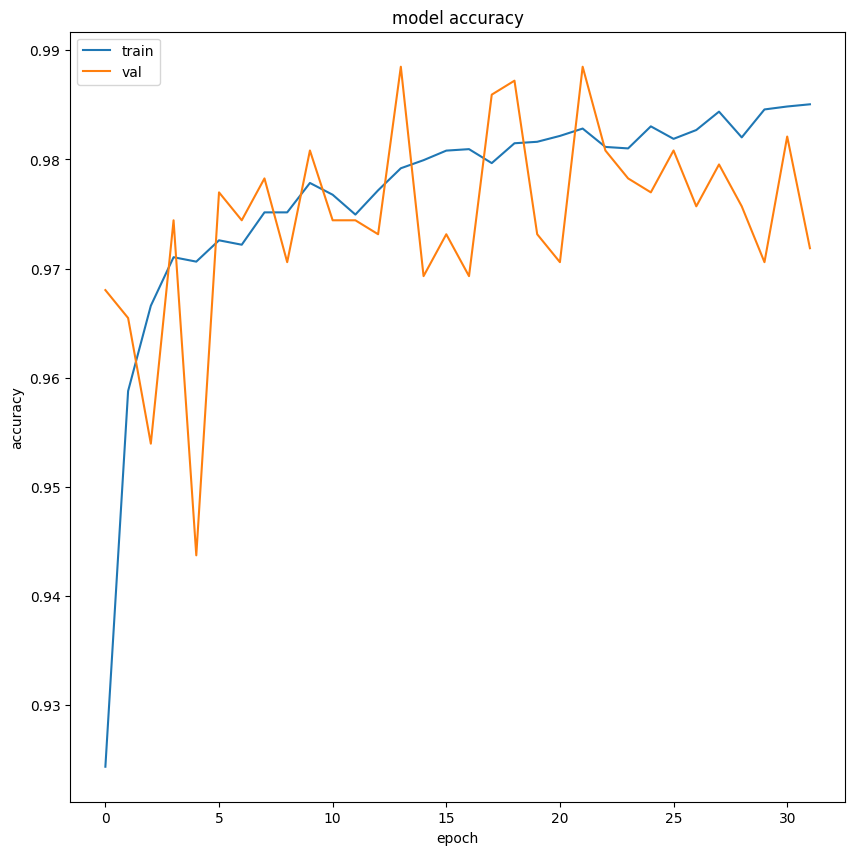

In [43]:
# Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

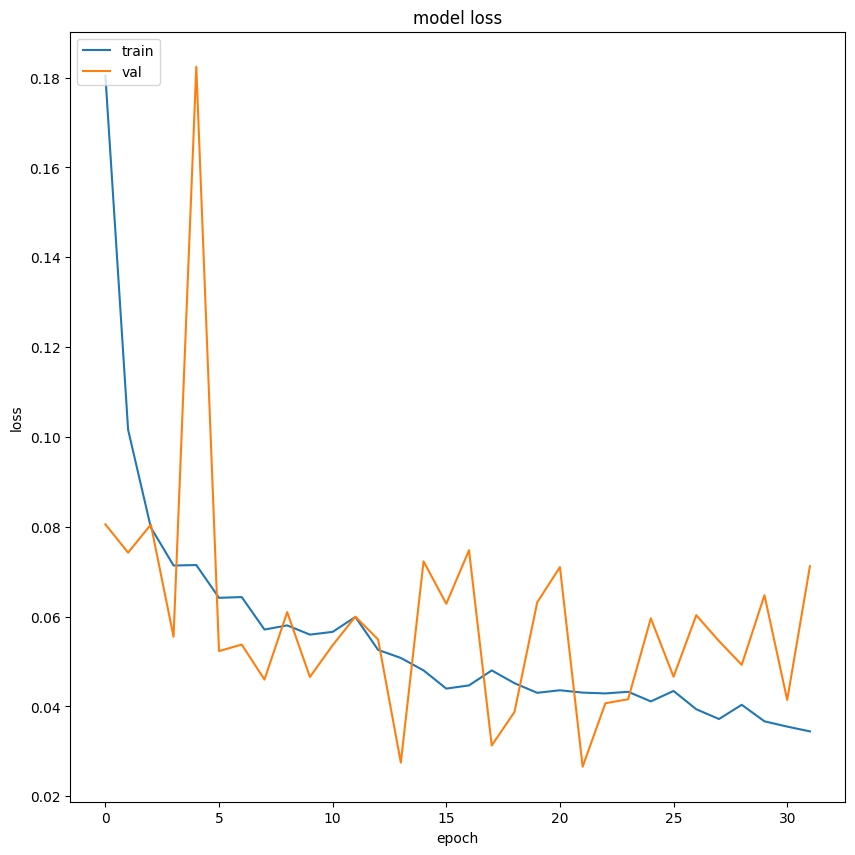

In [44]:
# Plot model loss for train and test sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [45]:
# Training metrics
scores = model.evaluate(seq_set_f25, label_set, verbose=1, batch_size=50)
print('Train Accurracy: {}'.format(scores[1]))

# Make predictions and compute confusion matrix
y_pred = (model.predict(seq_set_f25, verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_set

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Train Precision = ', precision, '\n', 'Train Recall = ', recall)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9851 - loss: 0.0325
Train Accurracy: 0.9852856397628784


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12392   139]
 [   91  3009]]
Train Precision =  0.9558449809402796 
 Train Recall =  0.9706451612903226


Model Evaluation on Test Set

3/3 - 0s - 165ms/step - accuracy: 0.9785 - loss: 0.0415
Total time taken for inferencing:  0.56  secs
Test Accurracy: 0.9784946441650391
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 1 24]]
Test Precision:  0.96 
 Test Recall:  0.96 
 Test F1-score: 0.96


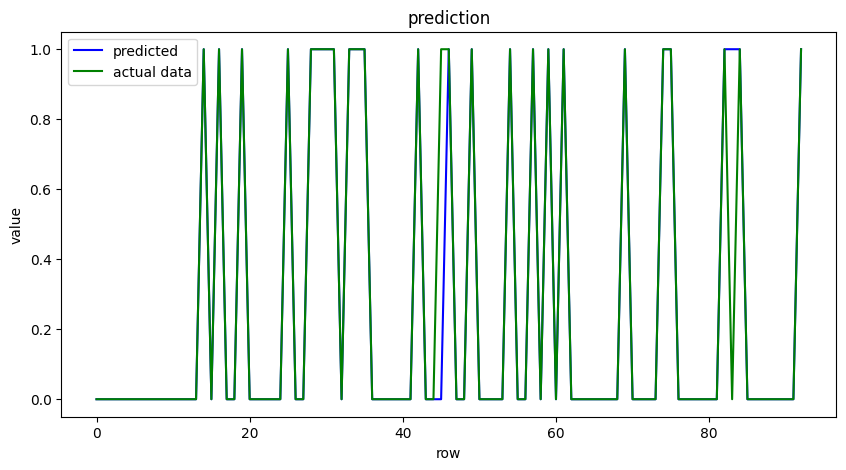

In [46]:
# Considering all the last sequences of test set
last_test_seq = [test_df[test_df['id']==id][sequence_cols_25].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

# Get labels of test set
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

# If best model weights were saved then load it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# Test metrics
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

print('Test Accurracy: {}'.format(scores_test[1]))

# Make predictions and compute confusion matrix
y_pred_test = (estimator.predict(last_test_seq) > 0.5).astype("int32")
y_true_test = last_test_label

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
conf_m = confusion_matrix(y_true_test, y_pred_test)
print(conf_m)

# Compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test,'\n', 'Test F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# Actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

In [47]:
pip install joblib

In [48]:
# ✅ Save model and scaler with names expected by app.py

# 1. Save the trained LSTM model
model.save("lstm_model.keras")

# 2. Save the MinMaxScaler
import joblib
joblib.dump(min_max_scaler, "scaler.pkl")

# 3. Save the sequence columns order (if your app uses it)
import json
with open("sequence_cols.json", "w", encoding="utf-8") as f:
    json.dump(sequence_cols_25, f, indent=2)

# 4. Download for local upload or GitHub commit
from google.colab import files
files.download("lstm_model.keras")
files.download("scaler.pkl")
files.download("sequence_cols.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Theory Explanation**


# 🔹 1. What is **cycle**?

* In your dataset:

  * `cycle` = **time step of engine usage**.
  * Example: Engine ID 1 runs from cycle 1 → cycle 192 until it fails.
  * Each cycle has sensor readings (temperature, pressure, vibration, etc.).
* Think of **cycle = day in the life of the engine**.

---

# 🔹 2. What are **timesteps** in the model?

* Neural networks don’t understand “time.” We must **feed data in chunks**.
* You chose `sequence_length = 50`.
* That means:

  * We take **50 consecutive cycles** (e.g., cycle 1–50, then 2–51, …).
  * This becomes **one training sample**.
* So:

  * **Timesteps = 50 cycles per sequence**
  * **Features per timestep = 25** (3 settings + 21 sensors + cycle\_norm)

---

# 🔹 3. Why **input weights** and **recurrent weights**?

### At each timestep:

* RNN computes:

  $$
  h_t = \tanh(W_x \cdot x_t + W_h \cdot h_{t-1} + b)
  $$

* **Input weights (W\_x):**

  * Connect **current sensor readings** (xₜ, shape = 25 features) → hidden state.
  * Learn how each sensor affects predictions.

* **Recurrent weights (W\_h):**

  * Connect **previous hidden state (hₜ₋₁)** → current hidden state.
  * This is the “memory” of the RNN → carries info from past cycles.

* **Bias (b):**

  * Helps model shift the activation for better learning.

👉 Together, they let the RNN combine **current cycle info** + **past memory**.

---

# 🔹 4. What does “training a 5-dimensional vector” mean?

* In your RNN: `units=5`.
* That means the hidden state **hₜ** has 5 values → `[hₜ¹, hₜ², hₜ³, hₜ⁴, hₜ⁵]`.
* So at every timestep (cycle), the RNN compresses **25 input features** into a **5D vector summary**.
* This 5D vector is the model’s **internal memory** of the engine’s condition so far.

---

# 🔹 5. Example — Aircraft Context

Imagine Engine 1, cycles 1–50:

* At each cycle, RNN updates its hidden state:

  * Input weights (W\_x) → read the 25 sensors.
  * Recurrent weights (W\_h) → carry info from the last cycle.
* After 50 cycles, hidden state (5 numbers) encodes the **trend of degradation**.
* Dense layer then maps that 5D summary → probability of failure (0–1).

---

# 🔹 6. Why not train directly on 25 features?

* If we used only the last cycle, the model **forgets past trends**.
* But failures often show as **gradual sensor drift**.
* The RNN hidden state keeps a **compressed memory** (5D vector) of those trends.
* That’s why we need **recurrent weights** and a hidden state.

---

# ✅ Simple Analogy

* Think of each cycle = a page in a diary (sensor readings).
* Input weights = how you “read” today’s page.
* Recurrent weights = how you **remember** yesterday’s notes.
* Hidden state (5D vector) = your **summary notes** that grow with each page.
* After 50 pages, your notes capture the **whole story** of engine health.

---




### 1. **Cycles (Timesteps)**

* On the left, you see **cycle 1 … cycle 50**.
* Each cycle = one timestep = one row of sensor readings (25 features).
* You group 50 cycles → this forms **one sequence** input for the model.

---

### 2. **Input Weights (Wₓ)**

* Every cycle’s 25 features are multiplied with **input weights**.
* This step learns how each sensor contributes to the hidden state.
* Example: vibration sensor may matter more than pressure → model learns that via weights.

---

### 3. **Recurrent Weights (Wₕ)**

* Connect the **previous hidden state** (memory) to the current step.
* This lets the model “remember” past cycles while processing the current one.
* Example: if temperature has been slowly rising for 30 cycles, recurrent weights ensure that trend influences the prediction.

---

### 4. **Hidden State (hₜ)**

* At every timestep, the RNN produces a **hidden state vector**.
* With 5 units → hidden state is a **5D vector**.
* This acts like a **compressed summary** of everything seen up to that cycle.

---

### 5. **Dense Layer**

* After all 50 cycles are processed, the **final hidden state** is passed to a **Dense (fully connected) layer**.
* This maps the 5D hidden state → a single probability (0–1).

---

### 6. **Output**

* The final output = **Failure Probability** (within 30 cycles).
* 0 = healthy, 1 = failure soon.
* During training, the model learns weights that minimize error between prediction and ground truth.

---

# ✅ Key Takeaways

* **Input Weights (Wₓ):** How current cycle features affect prediction.
* **Recurrent Weights (Wₕ):** How past memory affects prediction.
* **Hidden State (5D):** The engine’s “health summary.”
* **Dense Layer:** Converts that summary into a failure probability.
* **Output:** Actionable prediction for maintenance.

---


---

# 🔹 Step 1: What is one sequence?

* A **sequence = 50 consecutive cycles (timesteps)** for **one engine**.
* Each cycle has **25 features** (sensors + settings).
* So 1 sequence = a matrix of shape `(50, 25)`.
* The RNN processes this into **one 5D hidden vector** (because `units=5`).

---

# 🔹 Step 2: How many sequences can we make per engine?

* Suppose Engine 1 runs for **192 cycles** before failure.
* With sequence length = 50, you can create:

  $$
  192 - 50 + 1 = 143 \text{ sequences}
  $$
* Each sequence is slightly shifted by 1 cycle → this is the **sliding window** technique.
* So for Engine 1, you get 143 training samples.

---

# 🔹 Step 3: Across the training dataset

* Training dataset has **many engines** (in NASA CMAPSS, around 100).
* Each engine contributes multiple sequences (depending on how many cycles it survived).
* After sliding windows across all engines, you get **tens of thousands of sequences**.
* In your notebook, this became about **20,631 training sequences**. ✅

---

# 🔹 Step 4: So how many 5D vectors?

* Each sequence → produces **1 hidden state (5D vector)**.
* So if you have 20,631 sequences in training → you create **20,631 such 5D vectors** during training.
* These vectors are then mapped (via Dense layer) to probabilities (0/1 labels).

---

# 🔹 Test Set

* In test, you don’t use *all sequences*.
* You only take the **last 50 cycles per engine**.
* Why? Because in real-world deployment, you only have the latest sensor readings when you want to predict.
* So for each test engine → exactly **1 sequence → 1 hidden state vector → 1 prediction**.
* If test has 100 engines, you get **100 predictions**.

---

✅ **Summary**

* Training: thousands of overlapping 50-cycle sequences → thousands of 5D vectors → labels.
* Test: only last 50 cycles per engine → one 5D vector per engine → prediction.

---
